# Streamlining the Process of Exploring Datasets

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

### Importing Datasets

In [5]:
#can run this if working in the same folder as the data
def read_data(survey_section, discipline, dataset):
    ''' Loads UCUES datasets present in the Data Mural Project GitHub Data Folder and returns the dataset as a pandas
    dataframe
    
    Params:
        survey_section  str, Shortened section name, ex: Satis 
        discipline    str, Shortened discipline name, ex: Hum
        dataset    int, the sub-dataset from the specified survey section 
    '''
    #Creates the path for where the file is located in the local environment
    file_path = "{}_data_{}_{}.csv".format(survey_section, discipline, dataset)
    DF = pd.read_csv(file_path, encoding='utf-16le', sep = '\t')
    return DF

In [14]:
def read_data_from_file_path(file_path, UCUES_dataset, survey_section, discipline, dataset):
    ''' Loads UCUES datasets present in the Data Mural Project GitHub Data Folder and returns the dataset as a pandas
    dataframe
    
    Params:
        file_path     str, file_path to the dataset on your local environment, ex: /Users/omarramos/Documents/Data_Mural_Project/Data
        UCUES_dataset   str, name of the UCUES survey section and sub-dataset number, ex: Satisfaction-1
        survey_section  str, Shortened section name, ex: Satis 
        discipline    str, Shortened discipline name, ex: Hum
        dataset    int, the sub-dataset from the specified survey section 
    '''
    #Creates the path for where the file is located in the local environment
    file_path = "{}/Data/UCUES-{}/{}_data_{}_{}.csv".format(file_path, UCUES_dataset,survey_section, discipline, dataset)
    DF = pd.read_csv(file_path, encoding='utf-16le', sep = '\t')
    return DF

### Open and merge datasets

In [15]:
# example for how to use the function to open datasets for different disciplines for the same section
# and for how to create a new dataframe with all the disciplines and their scores merged together
def create_dataset(file_path, UCUES_dataset, survey_section, dataset):
    disciplines = ["Arts", "Hum", "Life", "Eng", "Health", "Phys", "Prof", "Social", "Undec"]
    dataset = dataset
    survey_section = survey_section
    file_path = file_path
    UCUES_dataset = UCUES_dataset
    
    #make array with the different datasets for each discipline
    array_dfs = []
    for discipline in disciplines:
        df = read_data_from_file_path(file_path, UCUES_dataset, survey_section, discipline, dataset)
        df[discipline] = [discipline for i in range(len(df))]
        array_dfs.append(df)
    
    #merge datasets for each discipline
    concat_df = pd.concat(array_dfs)
    
    # entries in one dataset & add this in a column so we can use later
    one_df_len = len(array_dfs[0])
    concat_df["Length of each dataframe"] = [one_df_len] * len(concat_df)
    
    #one-hot encode discipline columns
    concat_df = concat_df.fillna(0) #convert NaNs to 0
    for discipline in disciplines:
        concat_df.loc[concat_df[discipline] == discipline, discipline] = 1
    
    # Get one hot encoding of column with scores
    one_hot = pd.get_dummies(concat_df['Pivot Field Values'])
    # Drop column with scores as it is now encoded
    one_hot_df = concat_df.drop('Pivot Field Values',axis = 1)
    # Join the encoded df
    one_hot_df = one_hot_df.join(one_hot)
    
    #rename columns
    one_hot_df = one_hot_df.rename(columns = {"Label1": "Statement", "Calculation1": "Percent_pop", 
                                              "Total": "Pop_raw_count"})
    
    #drop duplicate rows
    new_df = one_hot_df.drop_duplicates()
    #reset index
    new_df = new_df.reset_index()
    
    #convert string percent column to actual percentages
    for x in range(len(new_df["Percent_pop"])):
        if type(new_df["Percent_pop"][x]) == str:
            new_df["Percent_pop"][x] = float(new_df["Percent_pop"][x].replace("%", ""))/100
    
    return new_df
    

In [16]:
def get_unique_scores(df):
    columns = []
    for col in df.columns:
        if type(col) != str:
            columns.append(col)
    return columns

### Exploratory Data Analysis

In [17]:
#how many people across all discplines relate to question on likert scale
def plot_total_scores(new_df, likert_scale):
    #get numeric columns, aka the scores
    cols = get_unique_scores(new_df)
    unique_stats = np.unique(new_df["Statement"])

    for stat in unique_stats:
        stat1_df = new_df.where(new_df["Statement"] == stat).dropna()
        stat1_all = stat1_df.groupby(cols).sum().drop(columns = "index") 
        stat1_all = stat1_all["Pop_raw_count"].reset_index().drop(columns = cols)
        stat1_all["Score"] = pd.get_dummies(cols[::-1]).idxmax(1)

        plt.figure(figsize=(5,5))
        plt.bar(stat1_all["Score"], stat1_all["Pop_raw_count"])
        plt.xlabel("Score")
        plt.ylabel("Population Raw Count")
        plt.title(stat)
        plt.xticks(cols, likert_scale, rotation=50);

In [18]:
# plotting data for specific disciplines
def plot_disciplines(new_df, likert_scale):
    disciplines = ["Arts", "Hum", "Life", "Eng", "Health", "Phys", "Prof", "Social", "Undec"]
    new_df["Discipline"] = disciplines * new_df["Length of each dataframe"][0]
    
    #get numeric columns, aka the scores
    cols = get_unique_scores(new_df)
    
    plot_df = new_df.drop(columns = cols + ["index"] + disciplines)
    
    unique_stats = np.unique(plot_df["Statement"])
    
    for stat in unique_stats:
        plot1 = plot_df.where(plot_df["Statement"] == stat).dropna()
        arr = []
        r = [arr.extend([x]* 9) for x in cols]
        plot1["Score_value"] = arr[::-1]
        arr2 = []
        r2 = [arr2.extend([x]* 9) for x in likert_scale]
        plot1["Score"] = arr2[::-1]

        plt.figure(figsize = (10,8))
        sns.barplot(data = plot1, x = "Discipline", y = "Pop_raw_count", hue = "Score", palette= "flare");
        plt.title(stat);
        plt.ylabel("Population Raw Count");

## Testing Functions on Dataset: Academic-Experience-1

**Question**: *In this academic year, how often have each of the following been obstacles to your school work or academic success?*

**Likert Scale**: Not at all (1), Rarely (2), Occasionally (3), Frequently (4), All the time (5)

### Creating Dataset

In [19]:
file_path = "/Users/emilylopez/Desktop/data_mural/data_mural_proj"
UCUES_dataset = "Academic-Experience-1"
survey_section = "Aca_Exp"
dataset = 1

new_df = create_dataset(file_path, UCUES_dataset, survey_section, dataset)

/var/folders/w4/mykv87ns3h3blj3jw28kzwd80000gn/T/ipykernel_15788/3799267883.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Percent_pop"][x] = float(new_df["Percent_pop"][x].replace("%", ""))/100


In [20]:
new_df.head()

,index,Statement,Percent_pop,Pop_raw_count,Arts,Hum,Life,Eng,Health,Phys,Prof,Social,Undec,Length of each dataframe,1,2,3,4,5
0,0,Reluctance to ask for academic help when I nee...,0.02,1.0,1,0,0,0,0,0,0,0,0,30,0,0,0,0,1
1,0,Reluctance to ask for academic help when I nee...,0.06,11.0,0,1,0,0,0,0,0,0,0,30,0,0,0,0,1
2,0,Reluctance to ask for academic help when I nee...,0.05,19.0,0,0,1,0,0,0,0,0,0,30,0,0,0,0,1
3,0,Reluctance to ask for academic help when I nee...,0.06,35.0,0,0,0,1,0,0,0,0,0,30,0,0,0,0,1
4,0,Reluctance to ask for academic help when I nee...,0.04,1.0,0,0,0,0,1,0,0,0,0,30,0,0,0,0,1


### Plotting total scores across disciplines combined

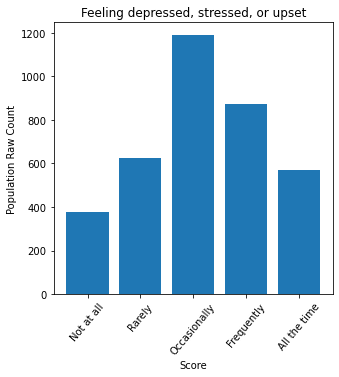

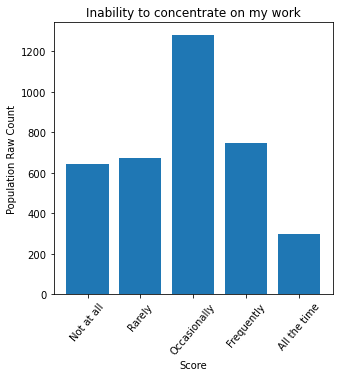

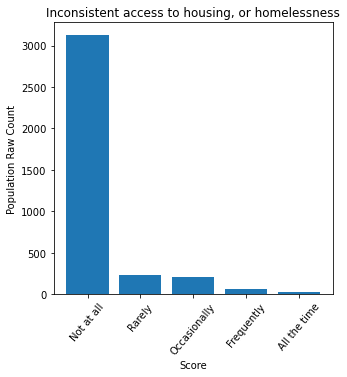

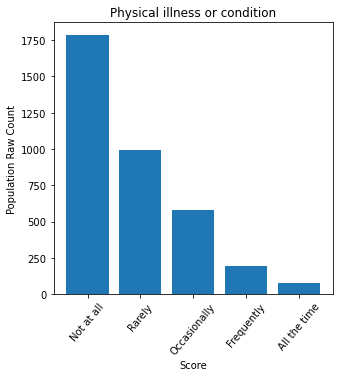

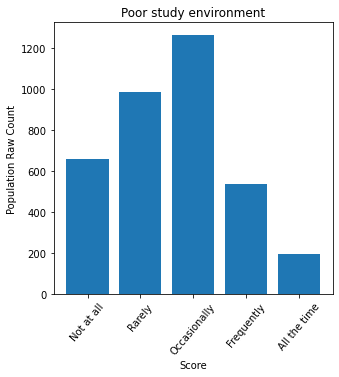

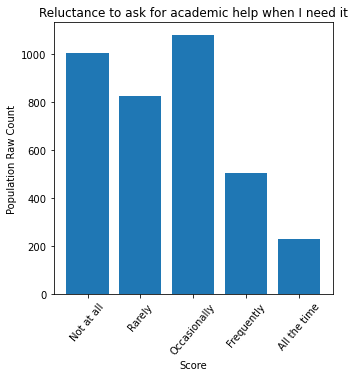

In [21]:
likert_scale = ["Not at all", "Rarely", "Occasionally", "Frequently", "All the time"]
plot_total_scores(new_df, likert_scale)

### Plotting data for specific disciplines

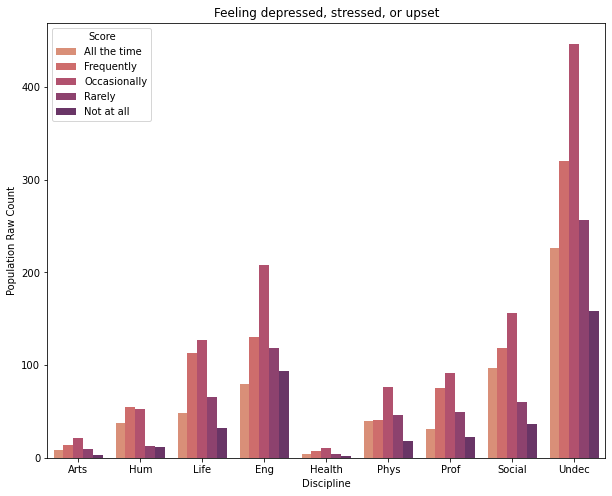

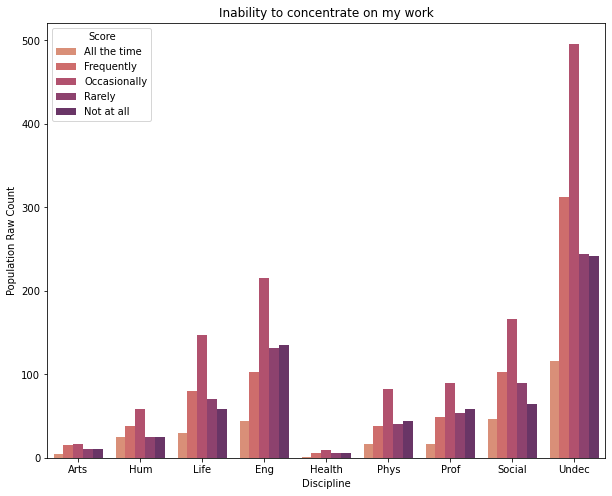

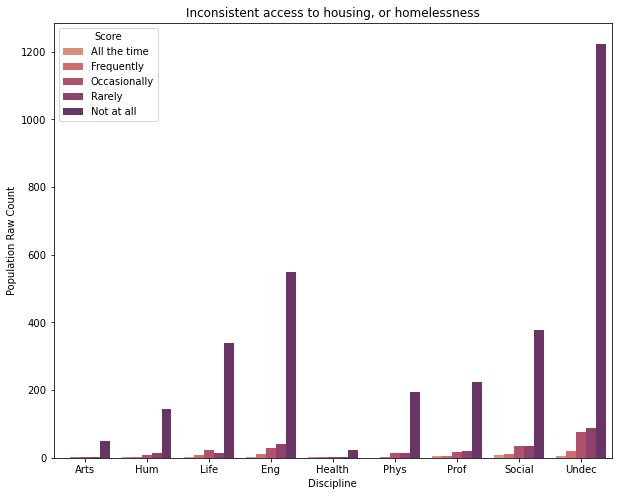

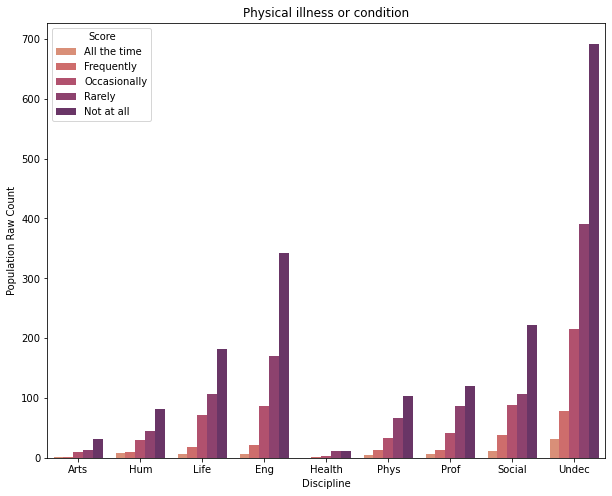

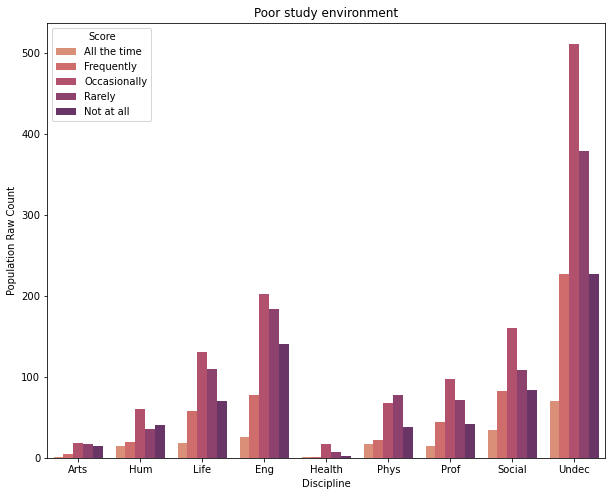

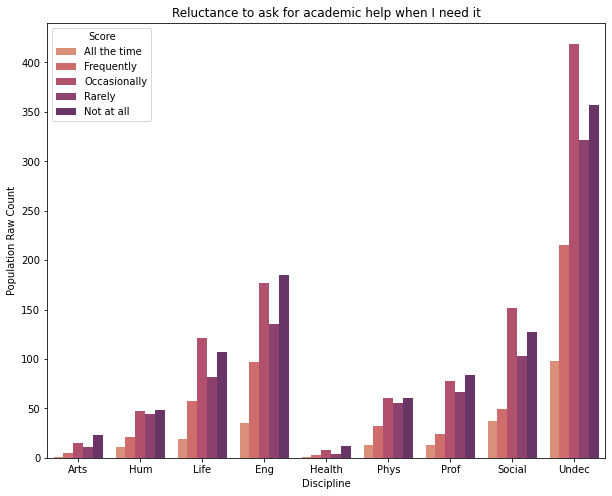

In [22]:
plot_disciplines(new_df, likert_scale)

## Testing Functions on Dataset: Satisfaction-1

**Question**: *Please select your level of agreement with the following statements.*

**Likert Scale**: Strongly Disagree (1), Disagree (2), Somewhat Disagree (3), Somewhat Agree (4), Agree (5), Strongly Agree (6)

### Creating Dataset

In [23]:
file_path = "/Users/emilylopez/Desktop/data_mural/data_mural_proj"
UCUES_dataset = "Satisfaction-1"
survey_section = "Satis"
dataset = 1

new_df = create_dataset(file_path, UCUES_dataset, survey_section, dataset)

/var/folders/w4/mykv87ns3h3blj3jw28kzwd80000gn/T/ipykernel_15788/3799267883.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Percent_pop"][x] = float(new_df["Percent_pop"][x].replace("%", ""))/100


In [24]:
new_df.head()

,index,Statement,Percent_pop,Pop_raw_count,Arts,Hum,Life,Eng,Health,Phys,Prof,Social,Undec,Length of each dataframe,1,2,3,4,5,6
0,0,Top campus administrators are genuinely commit...,0.17,27,1,0,0,0,0,0,0,0,0,42,0,0,0,0,0,1
1,0,Top campus administrators are genuinely commit...,0.11,61,0,1,0,0,0,0,0,0,0,42,0,0,0,0,0,1
2,0,Top campus administrators are genuinely commit...,0.1,123,0,0,1,0,0,0,0,0,0,42,0,0,0,0,0,1
3,0,Top campus administrators are genuinely commit...,0.12,239,0,0,0,1,0,0,0,0,0,42,0,0,0,0,0,1
4,0,Top campus administrators are genuinely commit...,0.1,13,0,0,0,0,1,0,0,0,0,42,0,0,0,0,0,1


### Plotting total scores across disciplines combined

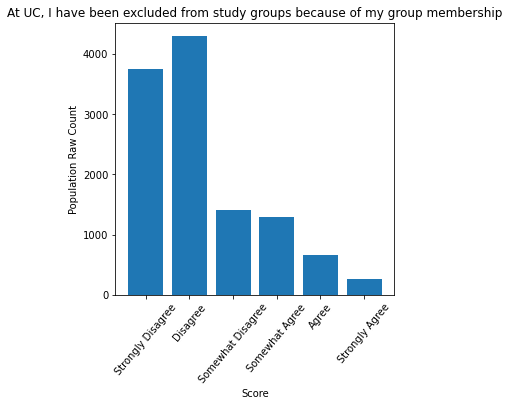

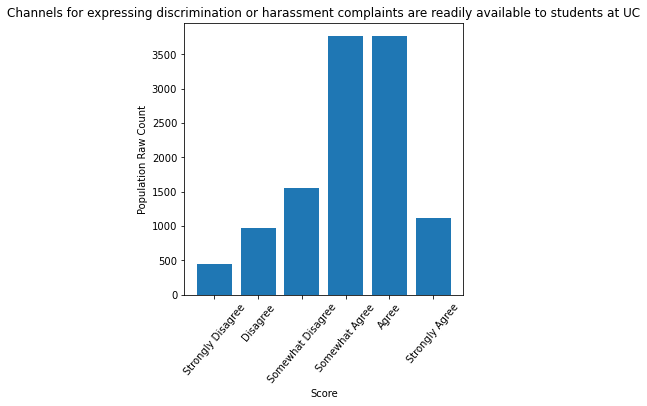

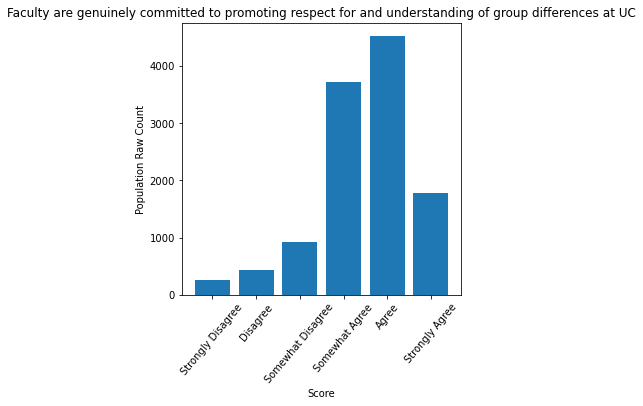

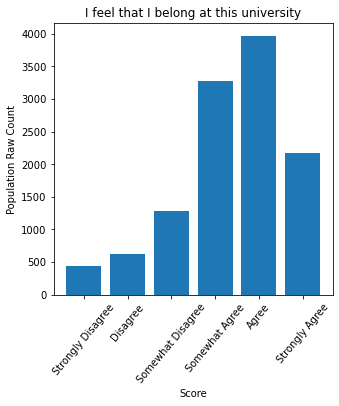

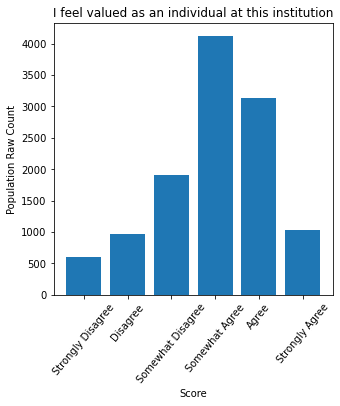

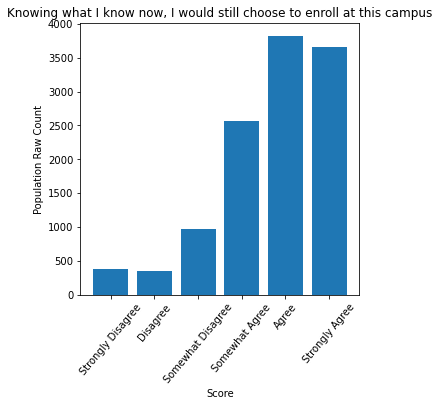

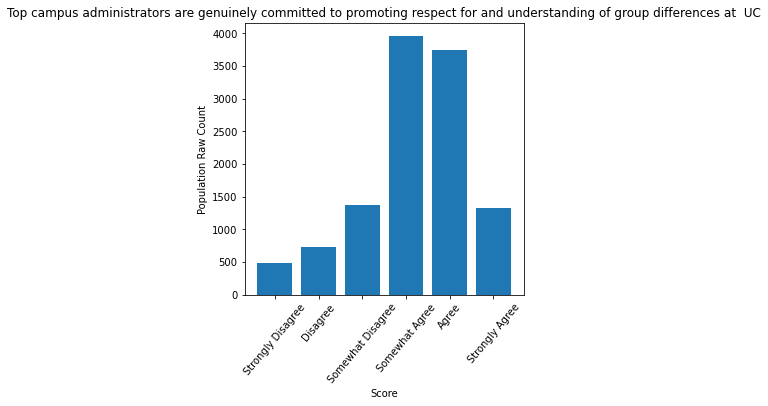

In [25]:
likert_scale = ["Strongly Disagree", "Disagree", "Somewhat Disagree", "Somewhat Agree", "Agree", "Strongly Agree"]
plot_total_scores(new_df, likert_scale)

### Plotting data for specific disciplines

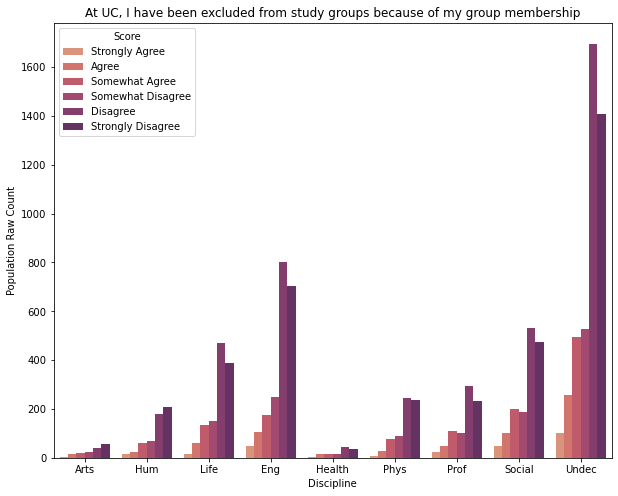

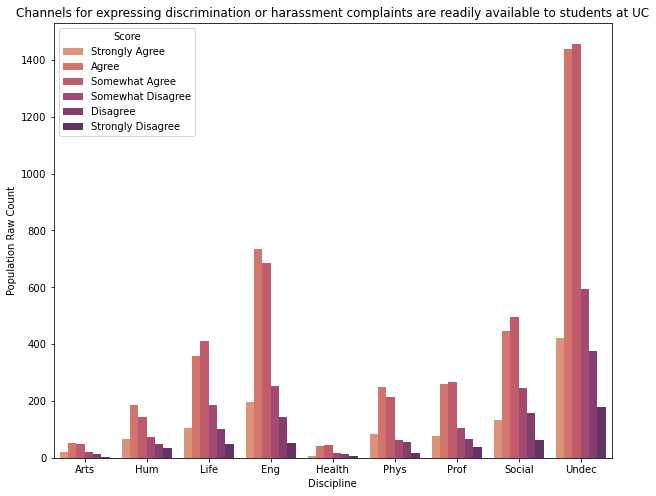

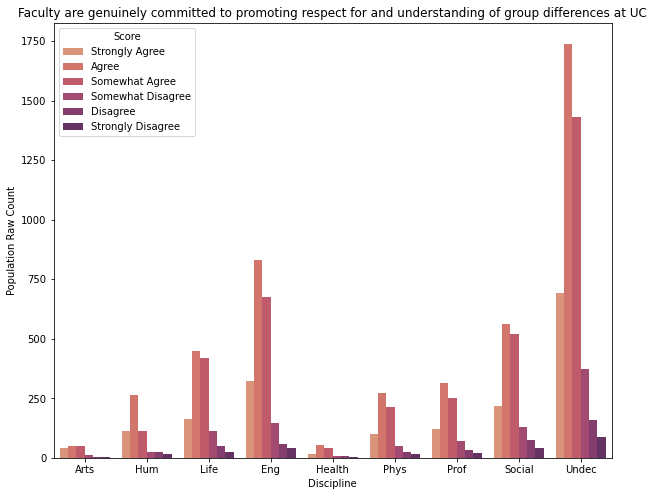

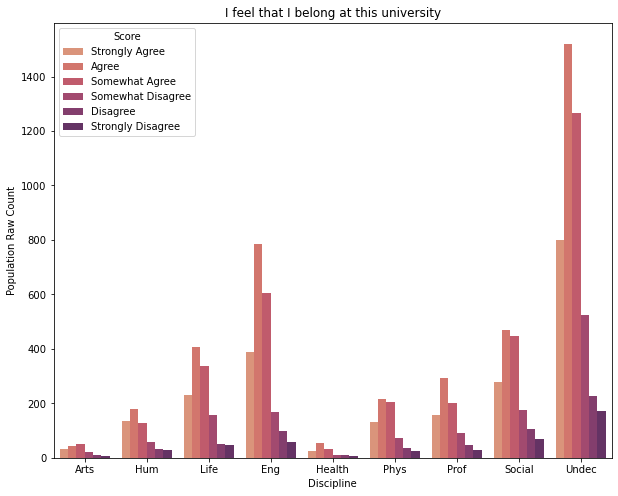

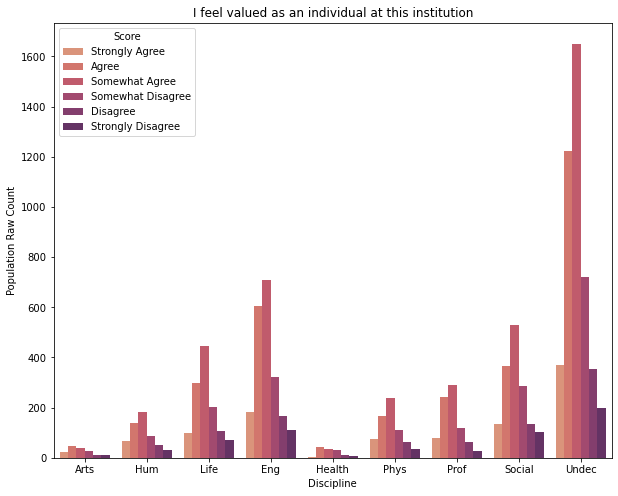

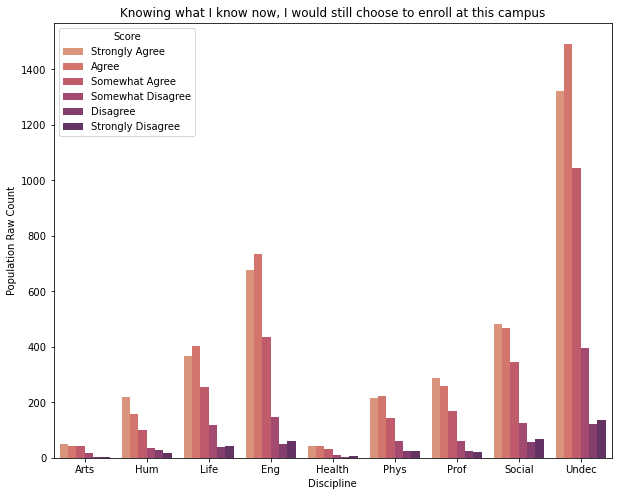

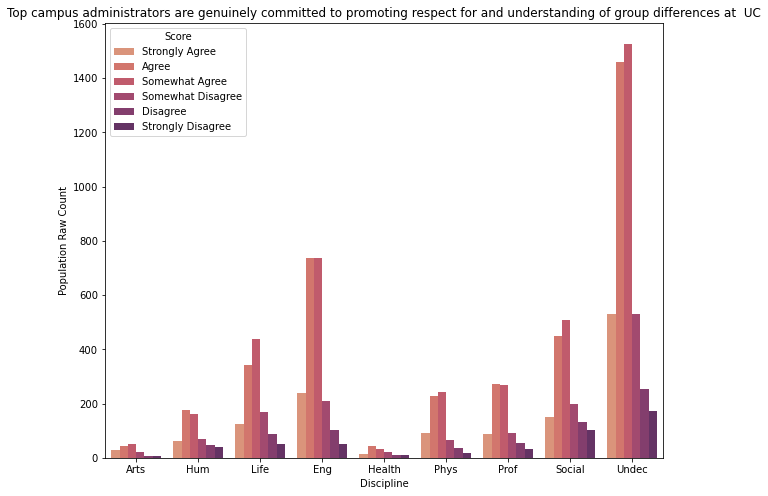

In [26]:
plot_disciplines(new_df, likert_scale)

## Testing Functions on Dataset: Campus-Climate-1

**Question**: *Please select your level of agreement with the following statements.*

**Likert Scale**: Strongly Disagree (1), Disagree (2), Somewhat Disagree (3), Somewhat Agree (4), Agree (5), Strongly Agree (6)

### Creating Dataset

In [30]:
file_path = "/Users/emilylopez/Desktop/data_mural/data_mural_proj"
UCUES_dataset = "Camp-Cli-1"
survey_section = "Camp_Cli"
dataset = 1

new_df = create_dataset(file_path, UCUES_dataset, survey_section, dataset)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/emilylopez/Desktop/data_mural/data_mural_proj/Data/UCUES-Camp-Cli-1/Camp_Cli_data_Arts_1.csv'

### Plotting total scores across disciplines combined

### Plotting data for specific disciplines

## Testing Functions on Dataset: Campus-Climate-2

**Question**: *Please indicate how strongly you agree or disagree with the following statement in terms of yourself.*

**Likert Scale**: Strongly Disagree (1), Disagree (2), Somewhat Disagree (3), Somewhat Agree (4), Agree (5), Strongly Agree (6), Not Applicable (-1)

### Creating Dataset

In [ ]:
file_path = "/Users/emilylopez/Desktop/data_mural/data_mural_proj"
UCUES_dataset = "Satisfaction-1"
survey_section = "Satis"
dataset = 1

new_df = create_dataset(file_path, UCUES_dataset, survey_section, dataset)

### Plotting total scores across disciplines combined

### Plotting data for specific disciplines